Cortex EAL: 279.0058413649777 microns
Relative White Matter EAL: 150.02493648069424 microns
Decay threshold cortex: 7.128761021025206
Decay threshold white matter: 0.0007068341205806939
Cortex slope: -0.012316673380309093, Cortex intercept: 5.400561268775052
White matter slope: -0.018792355087540107, White matter intercept: 11.011923216337069
White Matter EAL Depth: 972.0249364806942


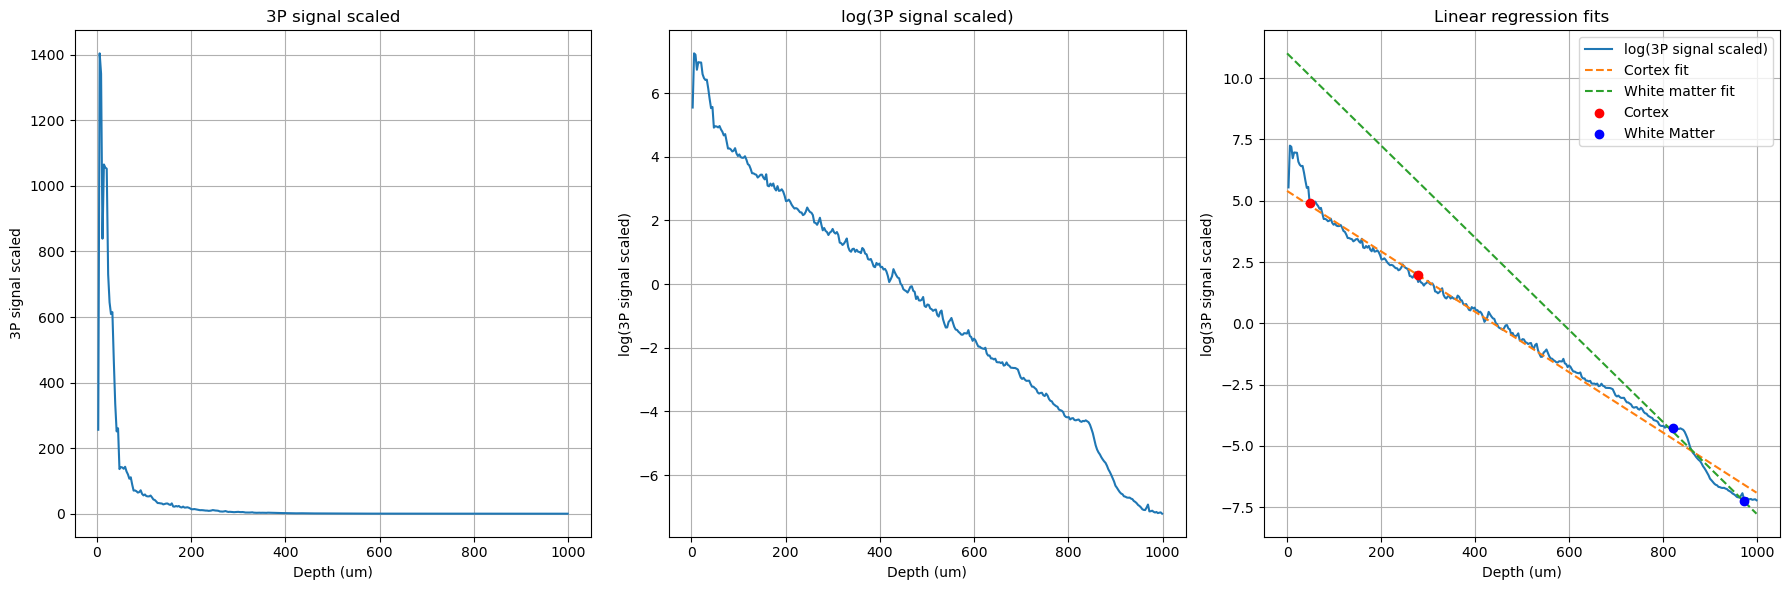

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define the parameters
file_path = '/Users/michaelthornton/Desktop/EAL data for Gibson Lab/Data/Example_data.xlsx'
repetition_rate = 1  # MHz
cortex_top = 48  # microns
white_matter_top = 822  # microns

def calculate_eal(file_path, repetition_rate, cortex_top, white_matter_top):
    # Load the data file
    df = pd.read_excel(file_path)

    # Convert the column "Average Power (mW) no overscan" to pulse energy at the surface
    df['Pulse energy at the surface (nJ)'] = df['Average Power (mW) no overscan'] / repetition_rate

    # Divide the column "Mean top 1% of pixels" by the cube of the column "Pulse energy at the surface (nJ)"
    df['3P signal scaled'] = df['Mean top 1% of pixels'] / (df['Pulse energy at the surface (nJ)'] ** 3)

    # Take the logarithm of the "3P signal scaled"
    df['log(3P signal scaled)'] = np.log(df['3P signal scaled'])

    # Perform linear regression for the cortex and white matter regions
    cortex_data = df[df['Depth (um)'] >= cortex_top]
    white_matter_data = df[df['Depth (um)'] >= white_matter_top]

    cortex_slope, cortex_intercept, _, _, _ = linregress(cortex_data['Depth (um)'], cortex_data['log(3P signal scaled)'])
    white_matter_slope, white_matter_intercept, _, _, _ = linregress(white_matter_data['Depth (um)'], white_matter_data['log(3P signal scaled)'])

    # Calculate the maximum signal in the cortex and white matter regions
    max_signal_cortex = cortex_data['3P signal scaled'].max()
    max_signal_white_matter = white_matter_data['3P signal scaled'].max()

    # Calculate the depth at which the signal decays to 1/e^3 of the maximum signal
    decay_threshold_cortex = max_signal_cortex / np.exp(3)
    decay_threshold_white_matter = max_signal_white_matter / np.exp(3)

    def find_eal_from_log_fit(slope, intercept, decay_threshold):
        log_decay_threshold = np.log(decay_threshold)
        eal_depth = (log_decay_threshold - intercept) / slope
        return eal_depth

    cortex_eal_depth = find_eal_from_log_fit(cortex_slope, cortex_intercept, decay_threshold_cortex)
    white_matter_eal_depth = find_eal_from_log_fit(white_matter_slope, white_matter_intercept, decay_threshold_white_matter)

    # Subtract white_matter_top from the calculated EAL for white matter
    relative_white_matter_eal_depth = white_matter_eal_depth - white_matter_top

    # Return all relevant variables
    return (df, cortex_eal_depth, relative_white_matter_eal_depth, 
            cortex_slope, cortex_intercept, white_matter_slope, 
            white_matter_intercept, decay_threshold_cortex, 
            decay_threshold_white_matter, white_matter_eal_depth)

# Calculate the EAL values
(df, cortex_eal_depth, relative_white_matter_eal_depth, 
 cortex_slope, cortex_intercept, white_matter_slope, 
 white_matter_intercept, decay_threshold_cortex, 
 decay_threshold_white_matter, white_matter_eal_depth) = calculate_eal(file_path, repetition_rate, cortex_top, white_matter_top)

# Print the results
print(f"Cortex EAL: {cortex_eal_depth} microns")
print(f"Relative White Matter EAL: {relative_white_matter_eal_depth} microns")
print(f"Decay threshold cortex: {decay_threshold_cortex}")
print(f"Decay threshold white matter: {decay_threshold_white_matter}")
print(f"Cortex slope: {cortex_slope}, Cortex intercept: {cortex_intercept}")
print(f"White matter slope: {white_matter_slope}, White matter intercept: {white_matter_intercept}")
print(f"White Matter EAL Depth: {white_matter_eal_depth}")

# Plotting
plt.figure(figsize=(18, 6))

# Plot 1: 3P signal scaled
plt.subplot(1, 3, 1)
plt.plot(df['Depth (um)'], df['3P signal scaled'], label='3P signal scaled')
plt.xlabel('Depth (um)')
plt.ylabel('3P signal scaled')
plt.title('3P signal scaled')
plt.grid(True)

# Plot 2: log(3P signal scaled)
plt.subplot(1, 3, 2)
plt.plot(df['Depth (um)'], df['log(3P signal scaled)'], label='log(3P signal scaled)')
plt.xlabel('Depth (um)')
plt.ylabel('log(3P signal scaled)')
plt.title('log(3P signal scaled)')
plt.grid(True)

# Plot 3: Linear regression fits on the log plot
plt.subplot(1, 3, 3)
plt.plot(df['Depth (um)'], df['log(3P signal scaled)'], label='log(3P signal scaled)')
plt.plot(df['Depth (um)'], cortex_slope * df['Depth (um)'] + cortex_intercept, label='Cortex fit', linestyle='--')
plt.plot(df['Depth (um)'], white_matter_slope * df['Depth (um)'] + white_matter_intercept, label='White matter fit', linestyle='--')

# Plot points where the decay threshold is reached
plt.scatter([cortex_eal_depth], [np.log(decay_threshold_cortex)], color='red', label='Cortex', zorder=5)
plt.scatter([white_matter_eal_depth], [np.log(decay_threshold_white_matter)], color='blue', label='White Matter', zorder=5)

# Plot points at cortex_top and white_matter_top
plt.scatter([cortex_top], [np.log(df[df['Depth (um)'] == cortex_top]['3P signal scaled'].values[0])], color='red', marker='o', zorder=5)
plt.scatter([white_matter_top], [np.log(df[df['Depth (um)'] == white_matter_top]['3P signal scaled'].values[0])], color='blue', marker='o', zorder=5)

plt.xlabel('Depth (um)')
plt.ylabel('log(3P signal scaled)')
plt.title('Linear regression fits')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


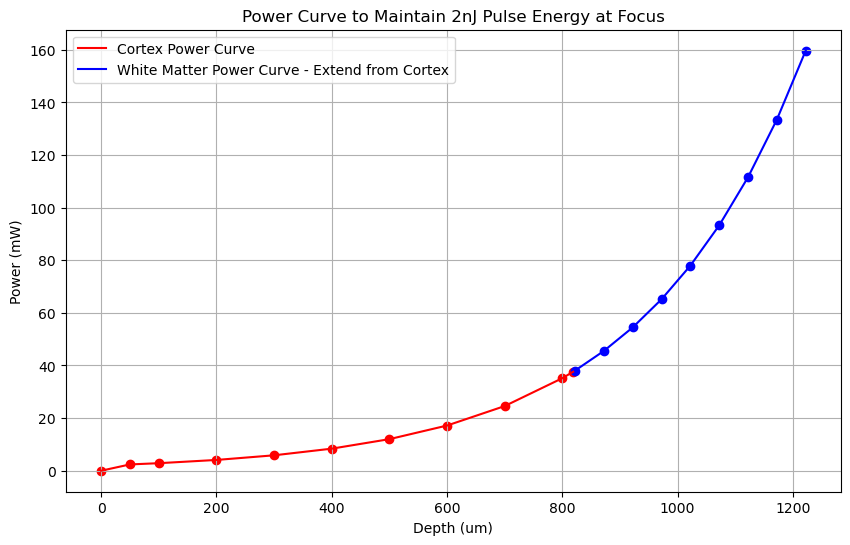

    Depth (um)  Power (mW)
0            0    0.000000
1           50    2.392538
2          100    2.862120
3          200    4.095866
4          300    5.861429
5          400    8.388057
6          500   12.003813
7          600   17.178177
8          700   24.583002
9          800   35.179751
10         819   37.658911
11         822   38.066021
12         872   45.537209
13         922   54.474761
14         972   65.166479
15        1022   77.956652
16        1072   93.257142
17        1122  111.560647
18        1172  133.456566
19        1222  159.649980


In [3]:
#Create power curves for cortex and white matter that maintain 2nJ pulse energy at the focus, based on the calculated EALs

desired_pulse_energy = 2  # nJ
total_depth_zstack = 1200 #micron

# Generate the power curve
depths_cortex = np.array([0, 50, 100, 200, 300, 400, 500, 600, 700, 800, white_matter_top - 3])
depths_extended = np.arange(white_matter_top, total_depth_zstack + 50, 50)

power_cortex = np.zeros_like(depths_cortex, dtype=float)
power_extended = np.zeros_like(depths_extended, dtype=float)

# Calculate power curve for cortex
for i, depth in enumerate(depths_cortex):
    if depth < cortex_top:
        power_cortex[i] = 0
    else:
        power_cortex[i] = desired_pulse_energy * np.exp(depth / cortex_eal_depth) * repetition_rate

# Extend the cortex power curve using the cortex EAL fit
for i, depth in enumerate(depths_extended):
    power_extended[i] = desired_pulse_energy * np.exp(depth / cortex_eal_depth) * repetition_rate

# Create a dataframe for the power values
power_data = pd.DataFrame({
    'Depth (um)': np.concatenate([depths_cortex, depths_extended]),
    'Power (mW)': np.concatenate([power_cortex, power_extended])
})

# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.plot(depths_cortex, power_cortex, label='Cortex Power Curve', color='red')
plt.plot(depths_extended, power_extended, label='White Matter Power Curve - Extend from Cortex', color='blue')
plt.scatter(depths_cortex, power_cortex, color='red')
plt.scatter(depths_extended, power_extended, color='blue')
plt.xlabel('Depth (um)')
plt.ylabel('Power (mW)')
plt.title('Power Curve to Maintain 2nJ Pulse Energy at Focus')
plt.legend()
plt.grid(True)
plt.show()

# Print the dataframe
print(power_data)

# Save the power_data dataframe to an output folder as .xlsx
output_folder = '/Users/michaelthornton/Desktop/Gene'  # Change this to your desired output folder
output_file_path = f'{output_folder}/power_data.xlsx'
power_data.to_excel(output_file_path, index=False)

